## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text_lines = text
text = "".join([line.lower() for line in text])

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [2]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2024-01-02 14:47:50--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2024-01-02 14:47:50 (13.5 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = "".join([x.replace('\t\t', '').lower() for x in text])


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
token_to_idx = dict(zip(tokens, range(len(tokens))))

# dict <char>:<index>
idx_to_token = dict(zip(token_to_idx.values(), token_to_idx.keys()))

In [6]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))

cuda device is available


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [7]:
class RNN(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)

        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        logits = self.rnn_to_logits(h_next)

        return h_next, F.log_softmax(logits, -1)

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True).to(device)

In [8]:
text_encoded = [token_to_idx[x] for x in text]

batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int)

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))

def train(model, batch, optimizer, criterion):
    model.zero_grad()
    hidden = model.initial_state(batch_size)
    logprobs = []

    for x_t in batch.transpose(0,1):
        hidden, logits = model(x_t, hidden)
        logprobs.append(logits)

    logprobs = torch.stack(logprobs, dim=1)
    pred = logprobs[:, :-1]
    actual_tokens = batch[:, 1:]

    loss = criterion(
        pred.contiguous().view(-1, len(tokens)),
        actual_tokens.contiguous().view(-1)
    )

    loss.backward()
    optimizer.step()

    return loss

In [ ]:


n_epochs = 30000

model = RNN()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

loss_history = []
start_time = time.time()

model.to(device)
model.train()

for epoch in range(1, n_epochs + 1):
    batch = torch.tensor(next(generate_chunk()), dtype=torch.int64)
    loss = train(model, batch.to(device), optimizer, criterion)
    loss_history.append(loss.cpu().detach().numpy())

time_elapsed = time.time() - start_time
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Training complete in 26m 12s


Plot the loss function (axis X: number of epochs, axis Y: loss function).

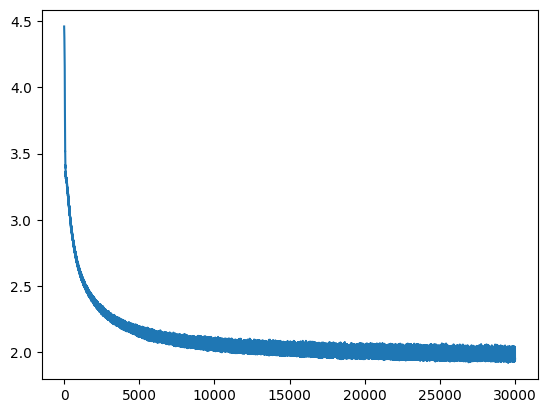

In [ ]:
plt.plot(loss_history,label='loss')
plt.show()

In [ ]:
torch.save(model, 'rnn')

In [ ]:
def generate_sample(model, seed_phrase=" мой дядя ", max_length=500, temperature=1.0, device=device):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hidden = model.initial_state(batch_size=1)
    model.eval()

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hidden, _ = model(x_sequence[:, i], hidden)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hidden, logp_next = model(x_sequence[:, -1], hidden)
        # Be really careful here with the model output
        p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [ ]:
# An example of generated text.
print(generate_sample(model, temperature=0.4))

 мой дядя своем вы доброй так счастливый не потом,
сердце поченный с страсти в полной
сама со сользы тайну, странный,
и последа на полной
и в подни волненье дворить в нем покой.



xxxi

«постар.
толка,
и старины
он старины не с порум в из все в ней не рода,
и не за тольною пора после не мой;
бой верний тебя старышать все должно моя полно красать в нем страшной простите в семность не простом
не в старико признаться месть страней,
и веселой постали добростный порой с простить она всем ольги всё н


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [9]:
class LSTM(nn.Module):
    def __init__(self, num_tokens=len(token_to_idx), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTMCell(embedding_size, rnn_num_units)
        self.f = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev, c_prev):
        x_emb = self.embedding(x)
        h, c = self.lstm(x_emb, (h_prev, c_prev))
        out = self.f(h)

        return h, c, F.log_softmax(out, -1)

    def initial_state(self, batch_size):
        return (torch.zeros(batch_size, self.num_units, requires_grad=True).to(device),
               torch.zeros(batch_size, self.num_units, requires_grad=True).to(device))

In [10]:
def train_lstm(model, batch, optimizer, criterion):
    model.zero_grad()
    hidden, cell = model.initial_state(batch_size)
    logprobs = []

    for x_t in batch.transpose(0,1):
        hidden, cell, logits = model(x_t, hidden, cell)
        logprobs.append(logits)

    logprobs = torch.stack(logprobs, dim=1)
    pred = logprobs[:, :-1]
    actual_tokens = batch[:, 1:]

    loss = criterion(
        pred.contiguous().view(-1, len(tokens)),
        actual_tokens.contiguous().view(-1)
    )

    loss.backward()
    optimizer.step()

    return loss

In [11]:


n_epochs = 30000

model = LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

loss_history = []
start_time = time.time()

model.to(device)
model.train()

for epoch in range(1, n_epochs + 1):
    batch = torch.tensor(next(generate_chunk()), dtype=torch.int64)
    loss = train_lstm(model, batch.to(device), optimizer, criterion)
    loss_history.append(loss.cpu().detach().numpy())

time_elapsed = time.time() - start_time
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Training complete in 31m 21s


Plot the loss function of the number of epochs. Does the final loss become better?

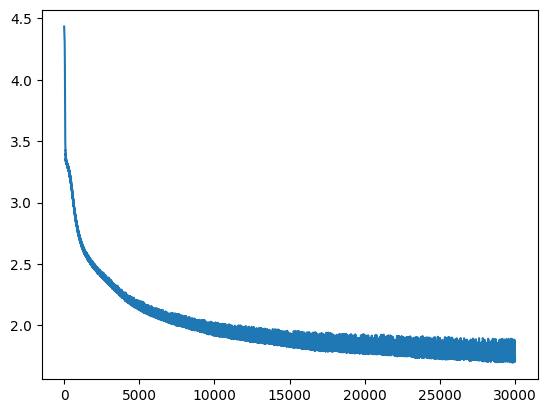

In [12]:
plt.plot(loss_history,label='loss')
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [13]:
# Text generation with different temperature values here

def generate_sample(model, seed_phrase=" мой дядя ", max_length=500, temperature=1.0, device=device):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hidden, cell = model.initial_state(batch_size=1)
    model.eval()

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hidden, cell, _ = model(x_sequence[:, i], hidden, cell)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hidden, cell, logp_next = model(x_sequence[:, -1], hidden, cell)
        # Be really careful here with the model output
        p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [16]:
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f'Temperature = {temp}')
    print(generate_sample(model, seed_phrase=" мой дядя ", max_length=100, temperature=temp))
    print("-"*100)

Temperature = 0.1
 мой дядя —
всё в сердце темно в совета в сердца,
под ней под сердце постелься воскрыть,
и странные 
----------------------------------------------------------------------------------------------------
Temperature = 0.2
 мой дядя —
всё в горов и не старины,
и в сердце подруга с ней,
и старинных слез ленский не страте
и
----------------------------------------------------------------------------------------------------
Temperature = 0.5
 мой дядя дам
сердечный страстной двор,
поедется был ремою долги
мечтой сон сердцем она.



xxxii

т
----------------------------------------------------------------------------------------------------
Temperature = 1.0
 мой дядя —
всё назнуч, мой, курять, черти овно
завсеков коранька пришувскае.
но кутой, разомноческв
----------------------------------------------------------------------------------------------------
Temperature = 2.0
 мой дядя с.
прачарканаями преесё в муею;
ищка кщет: в гогодпыдрясь.
счою. гретчись думовы лас лет,

-

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [26]:
torch.save(model, 'lstm')
model = torch.load('lstm')

print(generate_sample(model, seed_phrase=" мой дядя самых честных ", max_length=300, temperature=0.8))

 мой дядя самых честных друг,
он так танг пустал не нет.
погорел он и полы забца,
предаме прелестель в казанов;
кокова к ней это жизнь в бугой!»



viii

томан, быть, гибной ленский;
он он, пуселись том.



xxxvi

предверпит и время не знаши!
как одишу тремя в дудих
и что не достокогих.
всё в мостою


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)